#### This notebook incorporates: 
- Decision Tree and Random Forest into the workflow. No parameters tuned. 
- Important Features Exploration on Random forest no params tuned. Explored charting. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from ipywidgets import interactive, FloatSlider
import imblearn.over_sampling

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve 

import time

%matplotlib inline

In [2]:
data = pd.read_csv('/Users/jennihawk/Documents/Data Science/Classification/Churn Project/Models/chatr_clean.csv')

In [3]:
data.head()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,InternetService_Fiber,InternetService_No,Contract_One_Year,Contract_Two_year,PaymentMethod_Crcard,...,DeviceProtection_No_internet_serv,DeviceProtection_Yes,TechSupport_No_internet_serv,TechSupport_Yes,StreamingTV_No_internet_serv,StreamingTV_Yes,StreamingMovies_No_internet_serv,StreamingMovies_Yes,PaperlessBilling_Yes,Churn_Yes
0,7590-VHVEG,0,1.0,29.85,29.85,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,5575-GNVDE,0,34.0,56.95,1889.50,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3668-QPYBK,0,2.0,53.85,108.15,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,7795-CFOCW,0,45.0,42.30,1840.75,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
4,9237-HQITU,0,2.0,70.70,151.65,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [4]:
data.shape

(7032, 32)

### Train - Test Setup
- Utilize Stratify Argument

In [5]:
features_in = ['SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'InternetService_Fiber', 'InternetService_No',
       'Contract_One_Year', 'Contract_Two_year', 'PaymentMethod_Crcard',
       'PaymentMethod_Electr_Check', 'PaymentMethod_Mailed_check',
       'MultipleLines_No_phone_serv', 'MultipleLines_Yes', 'Dependents_Yes',
       'gender_Male', 'Partner_Yes', 'PhoneService_Yes',
       'OnlineSecurity_No_internet_serv', 'OnlineSecurity_Yes',
       'OnlineBackup_No_Internet_Serv', 'OnlineBackup_Yes',
       'DeviceProtection_No_internet_serv', 'DeviceProtection_Yes',
       'TechSupport_No_internet_serv', 'TechSupport_Yes',
       'StreamingTV_No_internet_serv', 'StreamingTV_Yes',
       'StreamingMovies_No_internet_serv', 'StreamingMovies_Yes',
       'PaperlessBilling_Yes']

y = data['Churn_Yes']
X = data[features_in]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5625, 30)
(1407, 30)
(5625,)
(1407,)


### Class Imbalance
Average rate of churn on target columm

In [6]:
np.mean(y_train)

0.2657777777777778

### Setup Oversampling
- Used 3x positive samples. Rationale: We have 3 to 1 ratio of negative to positive observations.
- Cross validation confirmed choice. 

In [7]:
# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 3, 0 : n_neg} 

# randomly oversample positive samples
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 

#use the fit_sample method to create the dataset with a desired proportion
#the variables X_tr_rs, y_tr_rs hold the training data with the extra samples we just created
X_tr_oversample, y_tr_oversample = ROS.fit_resample(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (4485) in class 1 will be larger than the number of samples in the majority class (class #0 -> 4130)
  warnings.warn(


### Oversampling Cross Validation - Determine how much to increase sample size 
- cross validation strategy for any parameter you want to tune
- doing cross validation on the oversampling to select which number would be best to increase the oversampling. The winner is 3.
- cv=10 knows to stratify when binary numbers

In [8]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)


# search for an optimal value of K for KNN
oversample_range = [1,2,3,4,5,6]
oversample_acc_scores = []
oversample_rec_scores = []
for oversample_weight in oversample_range:
    # oversample your data
    ratio = {1 : n_pos * oversample_weight, 0 : n_neg} 
    # randomly oversample positive samples: create 4x as many 
    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42)

    #use the fit_sample method to create the dataset with a desired proportion
    #the variables X_tr_rs, y_tr_rs hold the training data with the extra samples we just created
    X_tr_oversample, y_tr_oversample = ROS.fit_resample(X_train, y_train)
    
    # cross validate it
    d_tree = DecisionTreeClassifier()
    acc_scores = cross_val_score(d_tree, X_tr_oversample, y_tr_oversample, cv=10, scoring='accuracy')
    rec_scores = cross_val_score(d_tree, X_tr_oversample, y_tr_oversample, cv=10, scoring='recall')
    oversample_acc_scores.append(acc_scores.mean())
    oversample_rec_scores.append(rec_scores.mean())


print("Oversample Recall Scores")
print(list(zip(oversample_range, oversample_rec_scores)))
print("Oversample Accuracy Scores")
print(list(zip(oversample_range, oversample_acc_scores)))

/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (4485) in class 1 will be larger than the number of samples in the majority class (class #0 -> 4130)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (5980) in class 1 will be larger than the number of samples in the majority class (class #0 -> 4130)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (7475) in class 1 will be larger than the number of samples in the majority class (class #0 -> 4130)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (8970) in class 1 will be larger than the number of samples in the majority class (class #0 -> 4130)
  warning

Oversample Recall Scores
[(1, 0.49493959731543624), (2, 0.8973244147157191), (3, 0.972826519249125), (4, 0.9913043478260869), (5, 0.9969244178138579), (6, 0.9983277591973243)]
Oversample Accuracy Scores
[(1, 0.7260390131666277), (2, 0.8401685393258427), (3, 0.894840483870533), (4, 0.9175074183976262), (5, 0.9350282158662271), (6, 0.9407633587786259)]


### Decision Tree

##### Model Setup

In [9]:
#scaled data to have apples to apples comparison with logistic regression
tree_pipe = Pipeline([('scaler', StandardScaler()), ('DecTree', DecisionTreeClassifier())])

In [10]:
#Fit Decision Tree Model to Training Data
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('DecTree', DecisionTreeClassifier())])

#### Hard Class Predictions - No Oversample Train Data

In [11]:
#predict churn / not churn

In [12]:
y_pred = tree_pipe.predict(X_test)

#### Setup up Oversample on Decision Tree Model

In [13]:
oversamp_tree_pipe = Pipeline([('scaler', StandardScaler()), ('DecTree', DecisionTreeClassifier())])

#### Fit the decision tree oversample model

In [14]:
#'X_tr_oversample', 'y_tr_oversample' hold the training data that contains the extra samples
oversamp_tree_pipe.fit(X_tr_oversample, y_tr_oversample)

Pipeline(steps=[('scaler', StandardScaler()),
                ('DecTree', DecisionTreeClassifier())])

#### Hard Class Predictions based on oversampling training data

In [15]:
#we keep same X_test
y_pred_oversamp_tree = oversamp_tree_pipe.predict(X_test)

### Random Forest - Setup Oversample
- Selects random samples from a given dataset
- Constructs a decision tree for each sample and get a prediction result from each decision tree
- Perform a vote for each predicted result
- Select the prediction result with the most votes as the final prediction

In [16]:
#estimators = number of trees in the forest - use default 100
randforest_oversamp = Pipeline([('scaler', StandardScaler()), ('RandForest', RandomForestClassifier(n_estimators=100))])

In [17]:
#fit model on oversample train data
randforest_oversamp.fit(X_tr_oversample, y_tr_oversample)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RandForest', RandomForestClassifier())])

#### Random Forest - Hard Class Predictions for Oversample 

In [86]:
y_pred_randfor_oversamp = randforest_oversamp.predict(X_test)

#### Results Random Forest Oversampled Model -  TEST Results

In [87]:
print("Random Forest Oversample")
print(f"Precision: {precision_score(y_test, y_pred_randfor_oversamp)}")
print(f"Recall: {recall_score(y_test, y_pred_randfor_oversamp)}")
print(f"F1: {f1_score(y_test, y_pred_randfor_oversamp)}")

Random Forest Oversample
Precision: 0.5802139037433155
Recall: 0.5802139037433155
F1: 0.5802139037433155


### Random Forest Important Features

In [88]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_tr_oversample, y_tr_oversample)

RandomForestClassifier(random_state=0)

In [89]:
start_time = time.time()

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


Elapsed time to compute the importances: 0.021 seconds


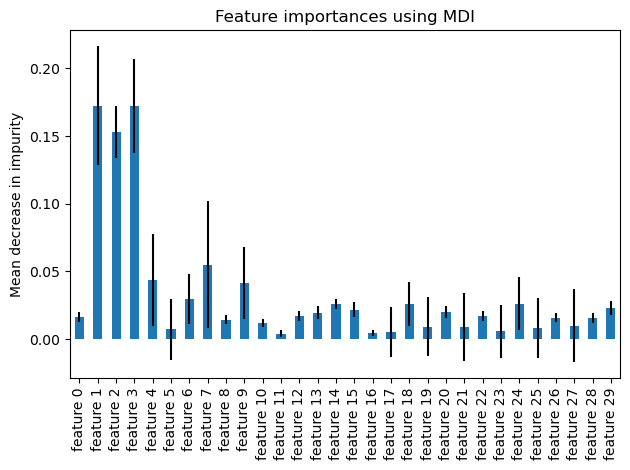

In [90]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Chart with Feature Names and sort vales

<AxesSubplot:>

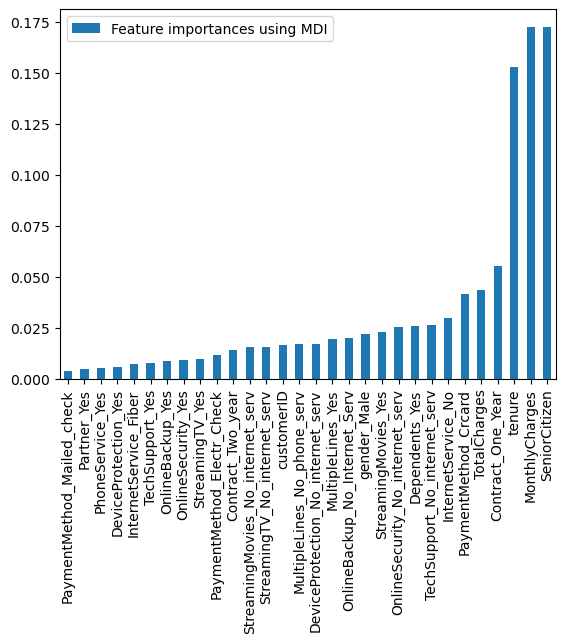

In [58]:
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data.columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Feature importances using MDI'})
importances.sort_values(by='Feature importances using MDI').plot(kind='bar')

#### Different Charting Options: Pandas and Seaborn

In [61]:
# feature_imp = pd.Series(forest.feature_importances_,index=feature_names).sort_values(ascending=False)
# feature_imp

In [62]:
# # Creating a bar plot
# sns.barplot(x=feature_imp, y=feature_imp.index)
# # Add labels to your graph
# plt.xlabel('Feature Importance Score')
# plt.ylabel('Features')
# plt.title("Visualizing Important Features")
# plt.legend()
# plt.show()


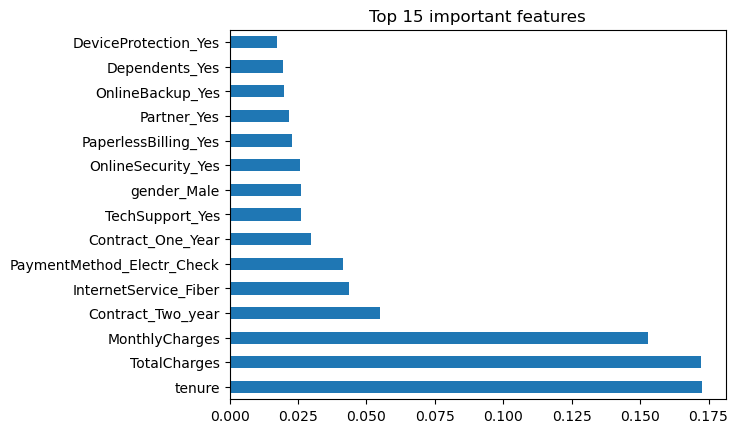

In [66]:
feat_importances = pd.Series(forest.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
#plt.savefig("RF_FeaturesImg.png", format="png", dpi=300)
plt.show()

### Logistic Regression Model - Setup Oversample

In [24]:
logreg_oversamp = Pipeline([('scaler', StandardScaler()), ('LogReg', LogisticRegression())])

In [25]:
#fit model on oversample train data
logreg_oversamp.fit(X_tr_oversample, y_tr_oversample)

Pipeline(steps=[('scaler', StandardScaler()), ('LogReg', LogisticRegression())])

#### Logistic Regression - Hard Class Predictions for Oversample 

In [26]:
y_pred_lr_oversamp = logreg_oversamp.predict(X_test)

#### Logistic Regression Oversampled Model - TEST SCORES

In [27]:
print("Logistic Regression Oversample")
print(f"Precision: {precision_score(y_test, y_pred_lr_oversamp)}")
print(f"Recall: {recall_score(y_test, y_pred_lr_oversamp)}")
print(f"F1: {f1_score(y_test, y_pred_lr_oversamp)}")

Logistic Regression Oversample
Precision: 0.4838709677419355
Recall: 0.8021390374331551
F1: 0.6036217303822937


#### Decision Tree Oversampled Model - TEST SCORES

In [28]:
print("Decision Tree Model Oversample")
print(f"Precision: {precision_score(y_test, y_pred_oversamp_tree)}")
print(f"Recall: {recall_score(y_test, y_pred_oversamp_tree)}")
print(f"F1: {f1_score(y_test, y_pred_oversamp_tree)}")

Decision Tree Model Oversample
Precision: 0.48128342245989303
Recall: 0.48128342245989303
F1: 0.48128342245989303


#### Decision Tree No Oversample - TEST SCORES
- The reason that these aren't drastically better than with oversample train data is because it can handle feature imbalance better

In [29]:
print("Decision Tree No Oversample ")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")

Decision Tree No Oversample 
Precision: 0.46368715083798884
Recall: 0.44385026737967914
F1: 0.453551912568306
